In [1]:
#  Create a ResNet model for Transfer Learning 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models  
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import sys 
sys.path.append('../Utils')  # To import utils from parent directory
import utils as ut
import configs
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score,classification_report
import numpy as np
import random
import os
import time
import copy
# Set random seeds for reproducibility
def set_seed(seed): 
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  
set_seed(42)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
#

In [2]:
#  Create The ResNet model class for transfer learning
class ResNetFineTune(nn.Module):
    def __init__(self, num_classes=7):  # 7 classes for multi-view
        super(ResNetFineTune, self).__init__()
        # Use ResNet50 for better feature extraction
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the last two blocks for fine-tuning
        for param in self.model.layer3.parameters():
            param.requires_grad = True
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # Regularization
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)
    


In [3]:
# Load & Transform data 

# Data transformations with augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
MULTIVIEW_TRAIN_DIR=configs.MULTIVIEW_TRAIN_DIR
MULTIVIEW_TEST_DIR=configs.MULTIVIEW_TEST_DIR
# Load datasets
def load_datasets():
    print("Loading datasets...")
    
    # Check if directories exist
    if not MULTIVIEW_TRAIN_DIR.exists():
        raise ValueError(f"Training directory {MULTIVIEW_TRAIN_DIR} does not exist")
    if not MULTIVIEW_TEST_DIR.exists():
        raise ValueError(f"Test directory {MULTIVIEW_TEST_DIR} does not exist")
    
    # Create datasets
    image_datasets = {
        'train': ImageFolder(root=MULTIVIEW_TRAIN_DIR, transform=data_transforms['train']),
        'test': ImageFolder(root=MULTIVIEW_TEST_DIR, transform=data_transforms['test'])
    }
    
    # Get class names
    class_names = image_datasets['train'].classes
    print(f"Found {len(class_names)} classes: {class_names}")
    
    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
        'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    }
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
    print(f"Dataset sizes: Train - {dataset_sizes['train']}, Test - {dataset_sizes['test']}")
    
    # Calculate class weights for imbalanced datasets
    train_targets = [label for _, label in image_datasets['train']]
    class_counts = np.bincount(train_targets)
    class_weights = 1. / class_counts
    class_weights = class_weights / class_weights.sum()
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    
    return dataloaders, class_names, dataset_sizes, class_weights_tensor

In [4]:
# Train Function 
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    
    # Initialize lists to track metrics
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            
            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().numpy())
            else:
                test_losses.append(epoch_loss)
                test_accs.append(epoch_acc.cpu().numpy())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model if it's the best so far on test set
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())
            
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f} at epoch {best_epoch}')

    
    # Return model and training history
    history = {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'train_acc': train_accs,
        'test_acc': test_accs
    }
    
    return model, history

In [5]:
# Evaluation function
def evaluate_model(model, dataloader, class_names):
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    return all_preds, all_labels, all_probs

In [6]:
# Main function
def main():
    # Load data
    dataloaders, class_names, dataset_sizes, class_weights = load_datasets()
    
    # Initialize model
    model = ResNetFineTune(num_classes=len(class_names)).to(device)
    
    # Loss function with class weights for imbalanced data
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizer with different learning rates for different parts of the network
    optimizer = optim.Adam([
        {'params': model.model.layer3.parameters(), 'lr': 1e-4},
        {'params': model.model.layer4.parameters(), 'lr': 1e-4},
        {'params': model.model.fc.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Train the model
    print("Starting training...")
    model, history = train_model(
        model, criterion, optimizer, scheduler, 
        dataloaders, dataset_sizes, num_epochs=60
    )
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_preds, test_labels, test_probs = evaluate_model(model, dataloaders['test'], class_names)
    
    
    return model, history, test_preds, test_labels, test_probs, class_names

if __name__ == '__main__':
    model, history, test_preds, test_labels, test_probs, class_names = main()

Loading datasets...
Found 7 classes: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']
Dataset sizes: Train - 2785, Test - 670
Starting training...
Epoch 1/60
----------


/Users/ayoub/work/prjt/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 1.6966 Acc: 0.3400
Test Loss: 1.2868 Acc: 0.5463

Epoch 2/60
----------
Train Loss: 1.2575 Acc: 0.5257
Test Loss: 1.1976 Acc: 0.5881

Epoch 3/60
----------
Train Loss: 1.2299 Acc: 0.5386
Test Loss: 1.0828 Acc: 0.6075

Epoch 4/60
----------
Train Loss: 1.0541 Acc: 0.5989
Test Loss: 0.9165 Acc: 0.6761

Epoch 5/60
----------
Train Loss: 1.0212 Acc: 0.6215
Test Loss: 1.1701 Acc: 0.5761

Epoch 6/60
----------
Train Loss: 1.0208 Acc: 0.6176
Test Loss: 0.7788 Acc: 0.7119

Epoch 7/60
----------
Train Loss: 0.9267 Acc: 0.6531
Test Loss: 0.8315 Acc: 0.6910

Epoch 8/60
----------
Train Loss: 0.9067 Acc: 0.6449
Test Loss: 1.0974 Acc: 0.6224

Epoch 9/60
----------
Train Loss: 0.9078 Acc: 0.6521
Test Loss: 0.7231 Acc: 0.7209

Epoch 10/60
----------
Train Loss: 0.8156 Acc: 0.6700
Test Loss: 0.6790 Acc: 0.7478

Epoch 11/60
----------
Train Loss: 0.7848 Acc: 0.6937
Test Loss: 0.6491 Acc: 0.7418

Epoch 12/60
----------
Train Loss: 0.7333 Acc: 0.7005
Test Loss: 0.6130 Acc: 0.7567

Epoch 13/60

In [21]:
from sklearn.metrics import recall_score, balanced_accuracy_score, f1_score, precision_score , classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("accuracy_score" , accuracy_score(test_labels, test_preds))
print("balanced_accuracy_score" , balanced_accuracy_score(test_labels, test_preds))
print("f1_score" , f1_score(test_labels, test_preds, average='weighted'))
print("recall_score" , recall_score(test_labels, test_preds, average='weighted'))
print("precision_score" , precision_score(test_labels, test_preds, average='weighted'))


accuracy_score 0.8059701492537313
balanced_accuracy_score 0.7980350213090329
f1_score 0.807888346115635
recall_score 0.8059701492537313
precision_score 0.819353095919404



📋 Classification Report:
              precision    recall  f1-score   support

         Ash       0.52      0.86      0.65        35
       Beech       0.87      0.81      0.84       160
 Douglas Fir       0.84      0.80      0.82       180
         Oak       0.80      0.60      0.69        20
        Pine       0.66      0.84      0.74        25
     Red Oak       0.83      0.95      0.88        95
      Spruce       0.83      0.74      0.78       155

    accuracy                           0.81       670
   macro avg       0.76      0.80      0.77       670
weighted avg       0.82      0.81      0.81       670



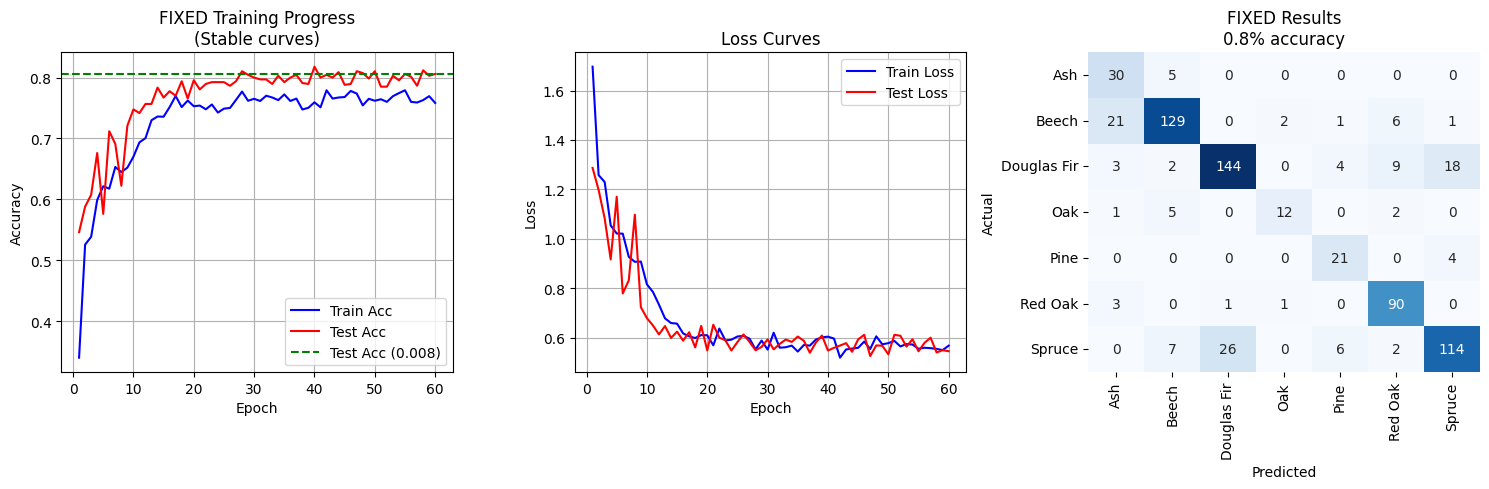

In [22]:
print(f"\n📋 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Plot results
plt.figure(figsize=(15, 5))

# Training curves
plt.subplot(1, 3, 1)
epochs = range(1, len(history['train_acc']) + 1)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
plt.plot(epochs, history['test_acc'], 'r-', label='Test Acc')
test_accuracy = history['test_acc'][-1] / 100  # Convert to fraction
plt.axhline(y=test_accuracy * 100, color='g', linestyle='--', label=f'Test Acc ({test_accuracy:.3f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FIXED Training Progress\n(Stable curves)')
plt.legend()
plt.grid(True)

# Loss curves
plt.subplot(1, 3, 2)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)

# Confusion matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
			xticklabels=class_names, yticklabels=class_names)
plt.title(f'FIXED Results\n{test_accuracy:.1%} accuracy')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

